In [408]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import random
import seaborn as sns

In [409]:
class Environment:
    def __init__(self, map_of_world):
        self.world_h = len(map_of_world)
        self.world_w = len(map_of_world[0])
        self.cargos = dict()
        self.desired_space = []
        # change r in a world map to -1
        modified_world = []
        for row in map_of_world:
            modified_row = []
            for c in row:
                if c == "r":
                    modified_row.append(-1)
                else:
                    modified_row.append(int(c))
            modified_world.append(modified_row)
        self.world = modified_world
        self.world = np.array(self.world)

        for y_coord in range(len(map_of_world)):
            for x_coord in range(len(map_of_world[0])):
                if map_of_world[y_coord][x_coord] == "r":
                    self.desired_space.append((y_coord, x_coord))
                if map_of_world[y_coord][x_coord].isdigit() and int(map_of_world[y_coord][x_coord]) != 0:
                    if map_of_world[y_coord][x_coord] not in self.cargos:
                        self.cargos[map_of_world[y_coord][x_coord]] = []
                    self.cargos[map_of_world[y_coord][x_coord]].append((y_coord, x_coord))
        for key in self.cargos:
            self.cargos[key] = np.array(self.cargos[key])

        self.desired_space = np.array(self.desired_space)

        self.init_cargos = self.cargos.copy()
        self.init_desired_space = self.desired_space.copy()
        self.init_world = self.world.copy()

    def move_cargo(self, cargo, action):
        if action == "D":
            new_pos = self.cargos[cargo] + np.array([1, 0])
        elif action == "U":
            new_pos = self.cargos[cargo] + np.array([-1, 0])
        elif action == "R":
            new_pos = self.cargos[cargo] + np.array([0, 1])
        elif action == "L":
            new_pos = self.cargos[cargo] + np.array([0, -1])
        else:
            raise ValueError("Action must be one of D, U, R, L")

        if np.any(new_pos < 0) or np.any(
            new_pos >= np.array([self.world_h, self.world_w])
        ):
            raise ValueError("New position is out of bounds")
        self.world[self.cargos[cargo][:, 0], self.cargos[cargo][:, 1]] = 0
        for y_des, x_des in self.desired_space:
            self.world[y_des, x_des] = -1
        self.world[new_pos[:, 0], new_pos[:, 1]] = int(cargo)
        self.cargos[cargo] = new_pos

    def check_move(self, cargo, action):
        if action == "D":
            new_pos = self.cargos[cargo] + np.array([1, 0])
        elif action == "U":
            new_pos = self.cargos[cargo] + np.array([-1, 0])
        elif action == "R":
            new_pos = self.cargos[cargo] + np.array([0, 1])
        elif action == "L":
            new_pos = self.cargos[cargo] + np.array([0, -1])
        else:
            raise ValueError("Action must be one of D, U, R, L")

        if np.any(new_pos < 0) or np.any(
            new_pos >= np.array([self.world_h, self.world_w])
        ):
            return False
        return True

    def world_visualisation(self):
        world = [[0 for _ in range(self.world_w)] for _ in range(self.world_h)]
        for space in self.desired_space:
            world[space[0]][space[1]] = "r"

        for key in self.cargos:
            for cargo_cell in self.cargos[key]:
                world[cargo_cell[0]][cargo_cell[1]] = key

        for world_y in range(len(world)):
            for world_x in range(len(world[0])):
                print(world[world_y][world_x], end=" ")
            print()

    def goal_distance(self, cargo):
        distances = []
        ids = []
        points = []
        for cargo_y, cargo_x in self.cargos[cargo]:
            min_y = 1e8
            min_x = 1e8
            id_y = -1
            id_x = -1
            min_cargo_point = (-1, -1)

            for des_y, des_x in self.desired_space:
                if abs(des_y - cargo_y) + abs(des_x - cargo_x) < min_y + min_x:
                    min_y = abs(des_y - cargo_y)
                    min_x = abs(des_x - cargo_x)
                    id_y = des_y
                    id_x = des_x
                    min_cargo_point = (cargo_y, cargo_x)
            distances.append(min_y + min_x)
            ids.append((id_y, id_x))
            points.append(min_cargo_point)
        min_id = np.argmax(distances)
        return distances[min_id], *ids[min_id], *points[min_id]

    def reset(self):
        self.cargos = self.init_cargos.copy()
        self.desired_space = self.init_desired_space.copy()
        self.world = self.init_world.copy()

    def get_cargo_overlaps(self, cur_cargo):
        # total_cells = []
        res = 0
        for cargo in self.cargos:
            if cargo == cur_cargo:
                continue
            for cell in self.cargos[cargo]:
                for cur_cell in self.cargos[cur_cargo]:
                    if cell[0] == cur_cell[0] and cell[1] == cur_cell[1]:
                        res += 1
        #                 total_cells.append(cell)
        # total_cells = np.array(total_cells)
        # unique, counts = np.unique(total_cells, axis=0, return_counts=True)
        # overlaped_cells = np.sum(counts > 1)
        return res

    def get_cargo_overlaps_with_desired(self, cargo):
        ret = 0
        for des_cell in self.desired_space:
            for cargo_cell in self.cargos[cargo]:
                if des_cell[0] == cargo_cell[0] and des_cell[1] == cargo_cell[1]:
                    ret += 1
        return ret

    def is_done(self):
        reward = 0
        # reward += self.get_cargo_overlaps_with_desired()
        for cargo in self.cargos:
            reward -= self.get_cargo_overlaps(cargo)
            reward += self.get_cargo_overlaps_with_desired(cargo)
        cargo_cells = 0
        for cargo in self.cargos:
            cargo_cells += len(self.cargos[cargo])
        return reward == cargo_cells

In [410]:
def generate_random_world():
    world_h = np.random.randint(5, 20)
    world_w = np.random.randint(5, 20)
    world = np.zeros((world_h, world_w))
    cargo_num = np.random.randint(1, 5)
    desired_h = np.random.randint(2, world_h)
    desired_w = np.random.randint(2, world_w)
    desired_corner_x = np.random.randint(0, world_w - desired_w)
    desired_corner_y = np.random.randint(0, world_h - desired_h)
    for y_shift in range(desired_h):
        for x_shift in range(desired_w):
            world[desired_corner_y + y_shift, desired_corner_x + x_shift] = -1
    for y_shift in range(1, cargo_num + 1):
        cargo_h = np.random.randint(1, world_h)
        cargo_w = np.random.randint(1, world_w)
        cells = []
        initial_cell = np.random.randint(0, world_h - cargo_h), np.random.randint(
            0, world_w - cargo_w
        )
        cells.append(initial_cell)
        cells_num = np.random.randint(0, 4)
        for x_shift in range(cells_num):
            moves = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            move = moves[np.random.randint(0, 4)]
            new_y, new_x = (cells[x_shift - 1][0] + move[0], cells[x_shift - 1][1] + move[1])
            new_cell = (new_y, new_x)
            while (
                new_cell[0] < 0
                or new_cell[0] >= world_h
                or new_cell[1] < 0
                or new_cell[1] >= world_w
            ):
                move = moves[np.random.randint(0, 4)]
                new_y, new_x = (cells[x_shift - 1][0] + move[0], cells[x_shift - 1][1] + move[1])
                new_cell = (new_y, new_x)
            cells.append(new_cell)
        cells = np.array(cells)
        world[cells[:, 0], cells[:, 1]] = y_shift
        # print(cells)
    return world

In [411]:
w = generate_random_world()
# write w into file
with open("world.txt", "w") as f:
    for i in range(w.shape[0]):
        for j in range(w.shape[1]):
            if w[i, j] == -1:
                f.write("r ")
            elif w[i, j] == 0:
                f.write("0 ")
            else:
                f.write(str(int(w[i, j])) + " ")
        f.write("\n")
# w

In [412]:
# read from input file
file = open("input.txt", "r")
world_map = []
for line in file:
    line = line.strip()
    line = line.split()
    world_map.append(line)
file.close()
env = Environment(world_map)

In [413]:
env.world_visualisation()

0 0 0 0 0 0 
0 0 0 2 0 3 
0 1 0 0 0 0 
0 0 0 r r 0 
0 6 0 r r 0 
0 0 0 r r 5 


In [414]:
class DQN(nn.Module):
    def __init__(self, output_size):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [415]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [416]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [417]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.5
EPS_END = 0.05
EPS_DECAY = 500
TARGET_UPDATE = 10

n_actions = 4

policy_net = DQN(n_actions).to(device)
target_net = DQN(n_actions).to(device)

In [418]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = np.random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(
        -1.0 * steps_done / EPS_DECAY
    )
    steps_done += 1
    if sample > eps_threshold:
        # print("policy")
        with torch.no_grad():
            return (policy_net(state.to(device)).max(1)[1].view(1, 1)).to("cpu")

    else:
        # print("random")
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

In [419]:
def get_state(environment, cargo=None):
    state = environment.world
    state = np.array(state)
    if cargo is not None:
        for other_cargo in environment.cargos:
            if other_cargo != cargo:
                state[environment.cargos[other_cargo][:, 0], environment.cargos[other_cargo][:, 1]] = -2
    state = state.reshape(1, 1, environment.world_h, environment.world_w)
    state = torch.from_numpy(state)
    state = state.float()
    return state


def get_reward(environment, possible, cargo, diff):
    reward = 0
    reward += environment.get_cargo_overlaps_with_desired(cargo)
    reward += diff
    reward -= environment.get_cargo_overlaps(cargo)
    reward -= 1
    if not possible:
        reward = -10
    return torch.tensor([reward], dtype=torch.float)

In [420]:
def get_cargo_state(state, cargo):
    state = state.detach().numpy()
    state = state.reshape(env.world_h, env.world_w)
    # print(state)
    for other_cargo in env.cargos:
        if other_cargo != cargo:
            state[env.cargos[other_cargo][:, 0], env.cargos[other_cargo][:, 1]] = -2
        else:
            state[env.cargos[other_cargo][:, 0], env.cargos[other_cargo][:, 1]] = 1
    new_state = state.reshape(1, 1, env.world_h, env.world_w)
    new_state = torch.from_numpy(new_state)
    new_state = new_state.float()
    return new_state

In [421]:
memory = ReplayMemory(10000)
optimizer = optim.Adam(policy_net.parameters())


def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool
    )
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE).to(device)
    next_state_values[non_final_mask] = (
        target_net(non_final_next_states.to(device)).max(1)[0].detach()
    )

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = F.smooth_l1_loss(
        state_action_values, expected_state_action_values.unsqueeze(1)
    )

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [422]:
def get_cargo_cells(environment):
    cells = 0
    for cargo in environment.cargos:
        cells += len(environment.cargos[cargo])
    return cells

In [423]:
actions_list = ["D", "U", "R", "L"]
MAX_STEPS = env.world_h * env.world_w * len(env.cargos)
MAX_STEPS

180

In [424]:
def get_random_env():
    random_world_map = generate_random_world()
    random_world_map = random_world_map.tolist()
    for map_line in random_world_map:
        for elem in map_line:
            if elem == -1:
                random_world_map[random_world_map.index(map_line)][map_line.index(elem)] = "r"
            else:
                random_world_map[random_world_map.index(map_line)][map_line.index(elem)] = str(
                    int(elem)
                )
    random_env = Environment(random_world_map)
    return random_env


r_env = get_random_env()

In [425]:
# for cargo, coords in env.cargos.items():
#     print(coords[0])

In [426]:
def read_env(input_path):
    global MAX_STEPS
    file = open(input_path, "r")
    world_map = []
    for line in file:
        line = line.strip()
        line = line.split()
        world_map.append(line)
    file.close()
    env = Environment(world_map)
    MAX_STEPS = env.world_h * env.world_w * len(env.cargos)
    return env

In [427]:
test_paths = ['testing/1.txt', 'testing/2.txt', 'testing/3.txt', 'testing/4.txt', 'testing/5.txt', 'testing/6.txt', 'testing/7.txt']
# env = read_env(test_paths[6])
# env.world_visualisation()
# dict with keys test_paths[i] and values 0
results_per_value = {test_paths[i]: (0,0) for i in range(len(test_paths))}

In [428]:
from IPython.core.display_functions import clear_output

total_train_rewards = []
episode_results = []
results = {"failed": 0, "success": 0}
# steps_done = 0


def train(n_episodes=1000):
    global env
    for i_episode in range(n_episodes):
        episode_env_path = np.random.choice(test_paths)
        env = read_env(episode_env_path)
        # env.reset()
        init_cargo_pos = env.cargos.copy()
        state = get_state(env)
        cargo_paths = dict()
        episode_reward_sum = 0
        steps = 0
        illegal_moves = 0
        cargo_cell_visits = dict()
        for cargo in env.cargos:
            cargo_cell_visits[cargo] = np.ones((env.world_h, env.world_w))
        while True:

            if steps > MAX_STEPS:
                results["failed"] += 1
                results_per_value[episode_env_path] = (results_per_value[episode_env_path][0] + 1, results_per_value[episode_env_path][1])
                break

            for cargo in env.cargos.keys():

                # cell = env.cargos[cargo][0]
                # cargo_cell_visits[cargo][cell[0], cell[1]] -= 1

                steps += 1
                cargo_state = get_cargo_state(state, cargo)
                action = select_action(cargo_state)
                is_possible_move = env.check_move(cargo, actions_list[action])

                before_overlap = env.get_cargo_overlaps(cargo)

                if not cargo_paths.get(cargo):
                    cargo_paths[cargo] = []

                cargo_paths[cargo].append(actions_list[action])
                if is_possible_move:
                    env.move_cargo(cargo, actions_list[action])
                else:
                    illegal_moves += 1

                after_overlap = env.get_cargo_overlaps(cargo)
                diff = after_overlap - before_overlap

                reward = get_reward(env, is_possible_move, cargo, diff)

                # reward += (cargo_cell_visits[cargo])[cell[0], cell[1]]


                if env.is_done():
                    # pass
                    reward += env.world_h * env.world_w  * get_cargo_cells(env)

                next_state = get_state(env)
                memory.push(state, action, next_state, reward)
                state = next_state
                optimize_model()
                episode_reward_sum += reward.item()
                # cargo_paths.append(path)
                if env.is_done():
                    break

            if env.is_done():
                results["success"] += 1
                results_per_value[episode_env_path] = (results_per_value[episode_env_path][0], results_per_value[episode_env_path][1] + 1)
                break
        if i_episode % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        print("Episode: {}, Reward: {}".format(i_episode, episode_reward_sum))
        total_train_rewards.append(episode_reward_sum)
        episode_results.append(env.is_done())
        print("Is done: {}".format(env.is_done()))
        print("Cargo positions: ")
        for cargo in env.cargos.keys():
            print(cargo, end=": ")
            for pos in env.cargos[cargo]:
                print(pos, end=" ")
            print()
        print("Initial cargo positions: ")
        for cargo in init_cargo_pos.keys():
            print(cargo, end=": ")
            for pos in init_cargo_pos[cargo]:
                print(pos, end=" ")
            print()
        print(f"steps performed: {steps}")
        print(f"illegal moves: {illegal_moves}")
        print("-" * 40)
        # clear output
        clear_output(wait=True)

In [429]:
train(700)

Episode: 699, Reward: -154.0
Is done: False
Cargo positions: 
2: [3 1] [3 2] 
1: [4 0] [4 1] 
Initial cargo positions: 
2: [0 2] [0 3] 
1: [4 1] [4 2] 
steps performed: 74
illegal moves: 13
----------------------------------------


In [430]:
results_per_value

{'testing/1.txt': (104, 4),
 'testing/2.txt': (14, 94),
 'testing/3.txt': (29, 66),
 'testing/4.txt': (35, 53),
 'testing/5.txt': (61, 34),
 'testing/6.txt': (19, 82),
 'testing/7.txt': (65, 40)}

In [431]:
results

{'failed': 327, 'success': 373}

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


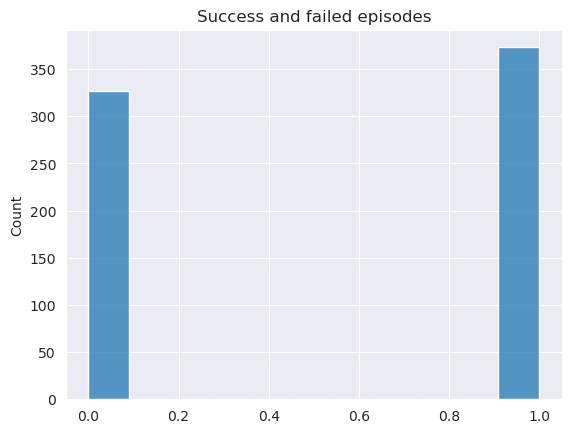

In [432]:
# compare failed and success
sns.histplot(episode_results)
plt.title("Success and failed episodes")
plt.show()

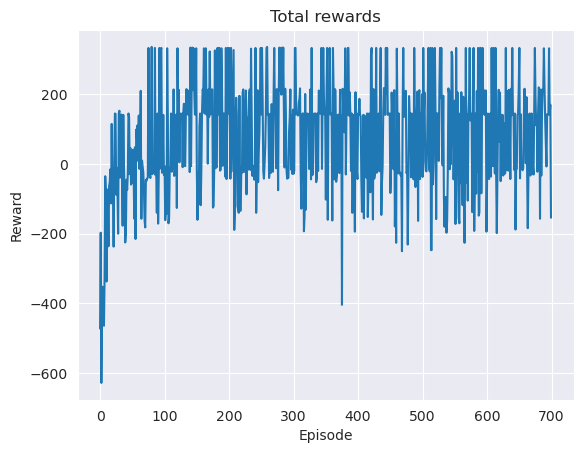

In [433]:
sns.lineplot(x=range(len(total_train_rewards)), y=total_train_rewards)
plt.title("Total rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

In [447]:
def test(n_episodes=1):
    global env
    for _ in range(n_episodes):
        env.reset()
        state = get_state(env)
        cargo_paths = dict()
        episode_reward_sum = 0
        steps = 0
        total_test_reward = 0

        # cargo_cells_visited = dict()
        # for cargo in env.cargos:
        #     cargo_cells_visited[cargo] = np.ones((env.world_h, env.world_w))
        while True:

            if steps > MAX_STEPS:
                break

            for cargo in env.cargos.keys():

                cell = env.cargos[cargo][0]
                # cargo_cells_visited[cargo][cell[0], cell[1]] -= 1

                steps += 1
                cargo_state = get_cargo_state(state, cargo)
                action = (
                    policy_net(cargo_state.to(device)).max(1)[1].view(1, 1).to("cpu")
                )
                is_possible_move = env.check_move(cargo, actions_list[action])

                before_overlap = env.get_cargo_overlaps(cargo)

                if not cargo_paths.get(cargo):
                    cargo_paths[cargo] = []

                cargo_paths[cargo].append(actions_list[action])
                if is_possible_move:
                    env.move_cargo(cargo, actions_list[action])
                else:
                    pass

                after_overlap = env.get_cargo_overlaps(cargo)
                diff = after_overlap - before_overlap

                reward = get_reward(env, is_possible_move, cargo, diff)
                # reward += (cargo_cells_visited[cargo])[cell[0], cell[1]]
                # if env.is_done():
                #     reward += env.world_h * env.world_w * get_cargo_cells(env)

                episode_reward_sum += reward.item()
                total_test_reward += reward.item()
                next_state = get_state(env)
                state = next_state
                if env.is_done():
                    break
            if env.is_done():
                break
        total_train_rewards.append(episode_reward_sum)
        episode_results.append(env.is_done())
        print("Is done: {}".format(env.is_done()))
        print("Reward: {}".format(total_test_reward))
        print("Cargo positions: ")
        for cargo in env.cargos.keys():
            print(cargo, end=": ")
            for pos in env.cargos[cargo]:
                print(pos, end=" ")
            print()
        print(f"steps performed: {steps}")
        print(f"cargo paths: {cargo_paths}")
        env.world_visualisation()
        print("-" * 40)
        return cargo_paths

In [448]:
paths = test()

Is done: True
Reward: -1.0
Cargo positions: 
1: [0 4] [1 4] 
steps performed: 3
cargo paths: {'1': ['R', 'R', 'R']}
0 0 0 0 1 0 
0 0 0 0 1 0 
----------------------------------------


In [449]:
for path in test_paths:
    print(path)
    env = read_env(path)
    env.world_visualisation()
    test()

testing/1.txt
0 0 0 2 0 0 
0 0 0 2 0 0 
0 1 0 0 0 r 
0 1 0 0 0 r 
0 0 0 0 0 r 
0 0 0 0 0 r 
Is done: False
Reward: -5.0
Cargo positions: 
2: [3 5] [4 5] 
1: [0 0] [1 0] 
steps performed: 74
cargo paths: {'2': ['D', 'R', 'R', 'D', 'D', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U'], '1': ['L', 'R', 'U', 'L', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U', 'D', 'U']}
1 0 0 0 0 0 
1 0 0 0 0 0 
0 0 0 0 0 r 
0 0 0 0 0 2 
0 0 0 0 0 2 
0 0 0 0 0 r 
----------------------------------------
testing/2.txt
0 0 2 2 0 0 
0 0 0 0 0 0 
0 0 r r 0 0 
0 0 r r 0 0 
0 1 1 0 0 0 
0 0 0 0 0 0 
Is done: True
Reward: 1.0
Cargo positions: 
2: [2 2] [2 3] 
1: [3 2] [3 3] 
steps performed: 4
cargo paths: {'2': ['D', 'D'], '1': ['U', 'R']}
0 0 0 0 0 0 
0 0 0 0 0 0 
0 0 2 2 0 0 
0 0 1 1 0 0 
0 0 0 

In [437]:
# save policy net
torch.save(policy_net.state_dict(), "policy_net.pth")
torch.save(target_net.state_dict(), "target_net.pth")

In [446]:
env = read_env('input.txt')
env.world_visualisation()
test()

0 1 0 0 r 0 
0 1 0 0 r 0 
Is done: True
Reward: 23.0
Cargo positions: 
1: [0 4] [1 4] 
steps performed: 3
cargo paths: {'1': ['R', 'R', 'R']}
0 0 0 0 1 0 
0 0 0 0 1 0 
----------------------------------------


{'1': ['R', 'R', 'R']}